## Table of Contents

- [Imports](#imports)
- [Pull Data](#pull-data)
- [Load Data](#load-data)
- [Data Preperation](#data-preperation)
- [Exploratory Data Analysis (EDA)](#eda)
- [Feature Selection](#feature-selection)
- [Data Split](#data-split)
- [Cross Validation and Final Model Training](#cv)
- [Feature Importance](#importance)
- [Catboost for Combination of Predictions](#combinations)
- [Testing/Results](#results)

<a id="imports"></a>
## Imports

In [2]:
import pandas as pd
from catboost import CatBoostRegressor, Pool

from ray.tune.search.hyperopt import HyperOptSearch
from ray import tune

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

import seaborn as sns
from matplotlib import pyplot as plt

from src.model_data.main import RunAllMethods
from src.ray_tuning.ray_tune import RayTune

<a id="pull-data"></a>
## Pull Data

In [3]:
# seasons = list(range(2018, 2024))
# end_date = '2023-07-28'

# driver_class = RunAllMethods(seasons, end_date)
# all_seasons = pd.DataFrame()

# for season in driver_class:
#     all_seasons = pd.concat([all_seasons, season])

In [4]:
# all_seasons.to_csv(f'data/full_run_{end_date}.csv', index=False)

<a id="load-data"></a>
## Load Data

In [5]:
season_df = pd.read_csv('data/full_run_2023-07-28.csv')
season_df

,Driver,DriverNumber,Time_min,Time_max,LapTimeSeconds_min,LapTimeSeconds_max,LapTimeSeconds_mean,LapTimeSeconds_std,LapTimeSeconds_count,Sector1TimeSeconds_min,...,TeamId,CountryCode,SessionType,SeasonYear,EventName,Position,Points,Country,Location,RoundNumber
0,ALO,14,0 days 00:30:47.908000,0 days 01:39:12.964000,85.896,115.334,93.453545,9.393776,11,28.485,...,mclaren,NaN,Practice 1,2018,Australian Grand Prix,5.0,10.0,Australia,Melbourne,1
1,ALO,14,0 days 00:12:20.531000,0 days 01:38:57.172000,85.200,148.222,98.449000,14.802200,23,28.165,...,mclaren,NaN,Practice 2,2018,Australian Grand Prix,5.0,10.0,Australia,Melbourne,1
2,ALO,14,0 days 00:23:58.601000,0 days 01:05:05.890000,94.298,122.320,105.187667,10.557891,9,30.927,...,mclaren,NaN,Practice 3,2018,Australian Grand Prix,5.0,10.0,Australia,Melbourne,1
3,BOT,77,0 days 00:25:57.761000,0 days 01:39:48.848000,84.577,122.941,96.972792,13.029348,24,28.037,...,mercedes,NaN,Practice 1,2018,Australian Grand Prix,8.0,4.0,Australia,Melbourne,1
4,BOT,77,0 days 00:12:42.794000,0 days 01:39:37.880000,84.159,130.373,96.584207,12.853744,29,27.725,...,mercedes,NaN,Practice 2,2018,Australian Grand Prix,8.0,4.0,Australia,Melbourne,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7743,SAI,55,0 days 00:18:50.731000,0 days 01:19:20.632000,78.234,138.377,92.125320,15.661716,25,28.203,...,NaN,ESP,Practice 3,2023,Hungarian Grand Prix,NaN,NaN,Hungary,Budapest,11
7744,SAI,55,0 days 00:16:44.589000,0 days 00:56:03.206000,77.703,130.067,97.556182,20.821290,11,28.084,...,NaN,ESP,Qualifying,2023,Hungarian Grand Prix,NaN,NaN,Hungary,Budapest,11
7745,VER,1,0 days 00:32:47.081000,0 days 01:19:38.911000,78.279,120.822,92.145923,16.045095,13,28.245,...,NaN,NED,Practice 2,2023,Hungarian Grand Prix,NaN,NaN,Hungary,Budapest,11
7746,VER,1,0 days 00:18:28.278000,0 days 01:19:50.325000,78.061,136.356,90.854611,15.584850,18,28.284,...,NaN,NED,Practice 3,2023,Hungarian Grand Prix,NaN,NaN,Hungary,Budapest,11


<a id="data-preperation"></a>
## Data Preperation

In [6]:
# Drop unneeded columns and remove driver session's with undefined points
model_data = season_df.drop(['Time_min', 'Time_max'], axis=1).copy()
model_data = model_data.dropna(subset=['Points'])

# List of categorical features
categorical_features = ['Driver', 'DriverNumber', 'Category', 'TeamId',
                        'CountryCode', 'Country', 'Location', 'EventName',
                        'SessionType', 'SeasonYear']

# List of integer features
integer_features = ['IsPersonalBest_pr_lap', 'RoundNumber', 'SeasonYear']

# List of float features
float_features = list(set(model_data.columns) - 
                      set(categorical_features) - 
                      set(integer_features))

# Convert categorical features to object
for feature in categorical_features:
    model_data[feature] = model_data[feature].astype(object)

# Convert integer features to int
for feature in integer_features:
    model_data[feature] = model_data[feature].astype(int)

# Convert float features to float
for feature in float_features:
    model_data[feature] = model_data[feature].astype(float)

In [7]:
# Fill na for categorical featues with '-1'
model_data.loc[:,model_data.dtypes == object] = (
    model_data.loc[:,model_data.dtypes == object].fillna('-1')
)

# Fill all other numerical feature na's with -1
model_data.loc[:,model_data.dtypes != object] = (
    model_data.loc[:,model_data.dtypes != object].fillna(-1)
)

<a id="eda"></a>
## Exploratory Data Analysis (EDA)

In [8]:
def get_points_charts(feature, mean_title, sum_title, query):

    # Query to grain of data based on feature - Per Driver, Season, and Event
    feature_df = (
        model_data.query(query)
                  .copy()
                  .groupby(['Driver',
                            'SeasonYear',
                            'EventName',
                            f'{feature}'])['Points']
                  .mean()
                  .reset_index()
    )

    # Mean and sum of metric
    feature_agg = (
        feature_df.groupby([f'{feature}',
                            'SeasonYear'])['Points']
                  .agg({'mean', 'sum'})
                  .reset_index()
    )

    # Plot Barplots
    fig = plt.figure()
    plt.style.use('ggplot')
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    sns.barplot(feature_agg.sort_values('mean', ascending=False),
                x='mean',
                y=f'{feature}',
                hue='SeasonYear',
                ax=ax1)
    ax1.title.set_text(mean_title)
    ax1.set_ylabel('Average Points')
    sns.barplot(feature_agg.sort_values('sum', ascending=False),
                x='sum',
                y=f'{feature}',
                hue='SeasonYear',
                ax=ax2)
    ax2.title.set_text(sum_title)
    ax2.set_ylabel('Total Points')
    sns.set(rc={'figure.figsize':(30, 20)})

    plt.show()

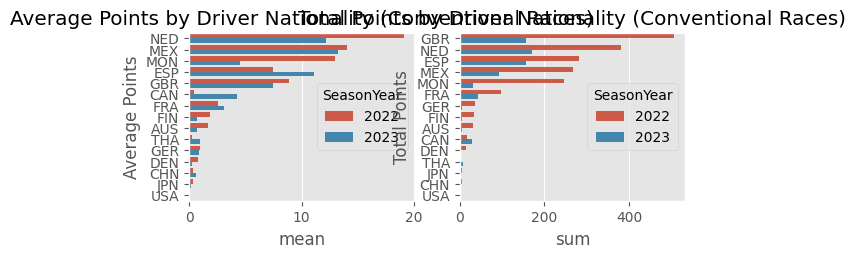

In [9]:
mean_title = 'Average Points by Driver Nationality (Conventional Races)'
sum_title = 'Total Points by Driver Nationality (Conventional Races)'
query = '(CountryCode != "-1") and SeasonYear >= 2022'
get_points_charts('CountryCode', mean_title, sum_title, query)

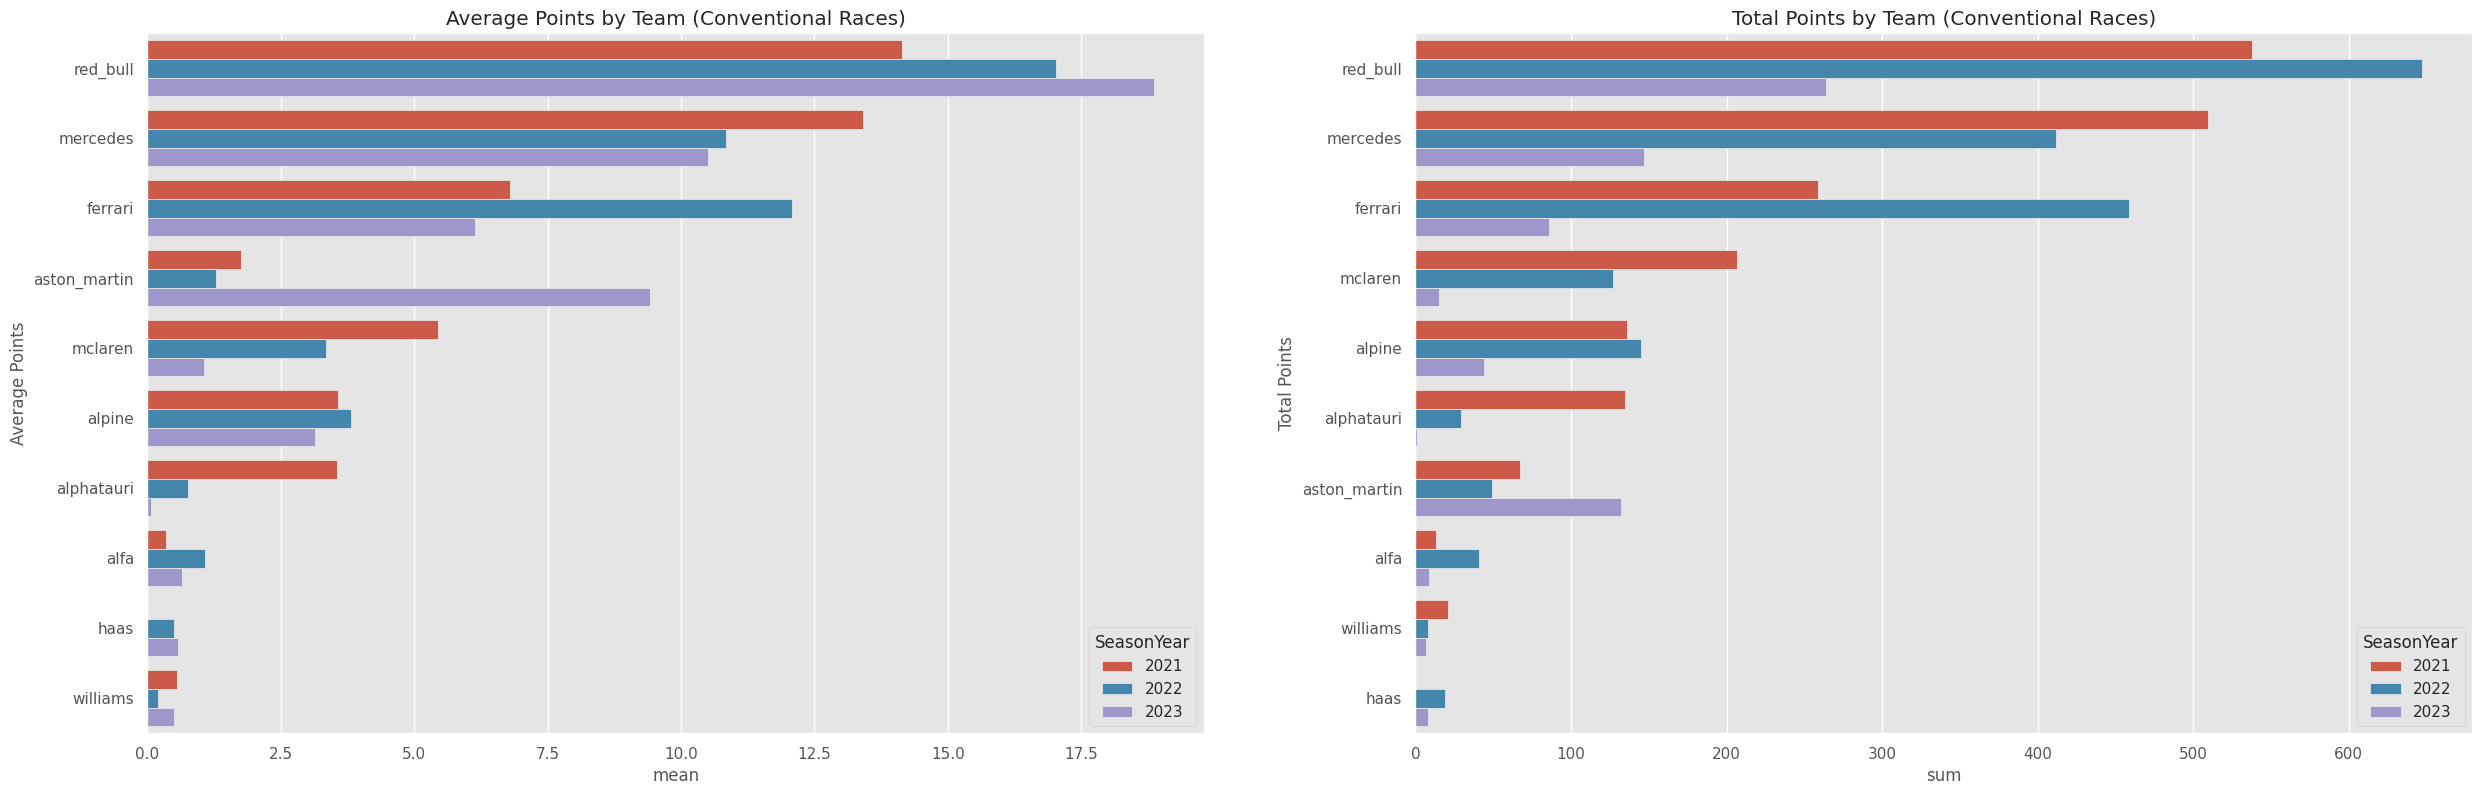

In [10]:
mean_title = 'Average Points by Team (Conventional Races)'
sum_title = 'Total Points by Team (Conventional Races)'
query = 'SeasonYear >= 2021'
get_points_charts('TeamId', mean_title, sum_title, query)

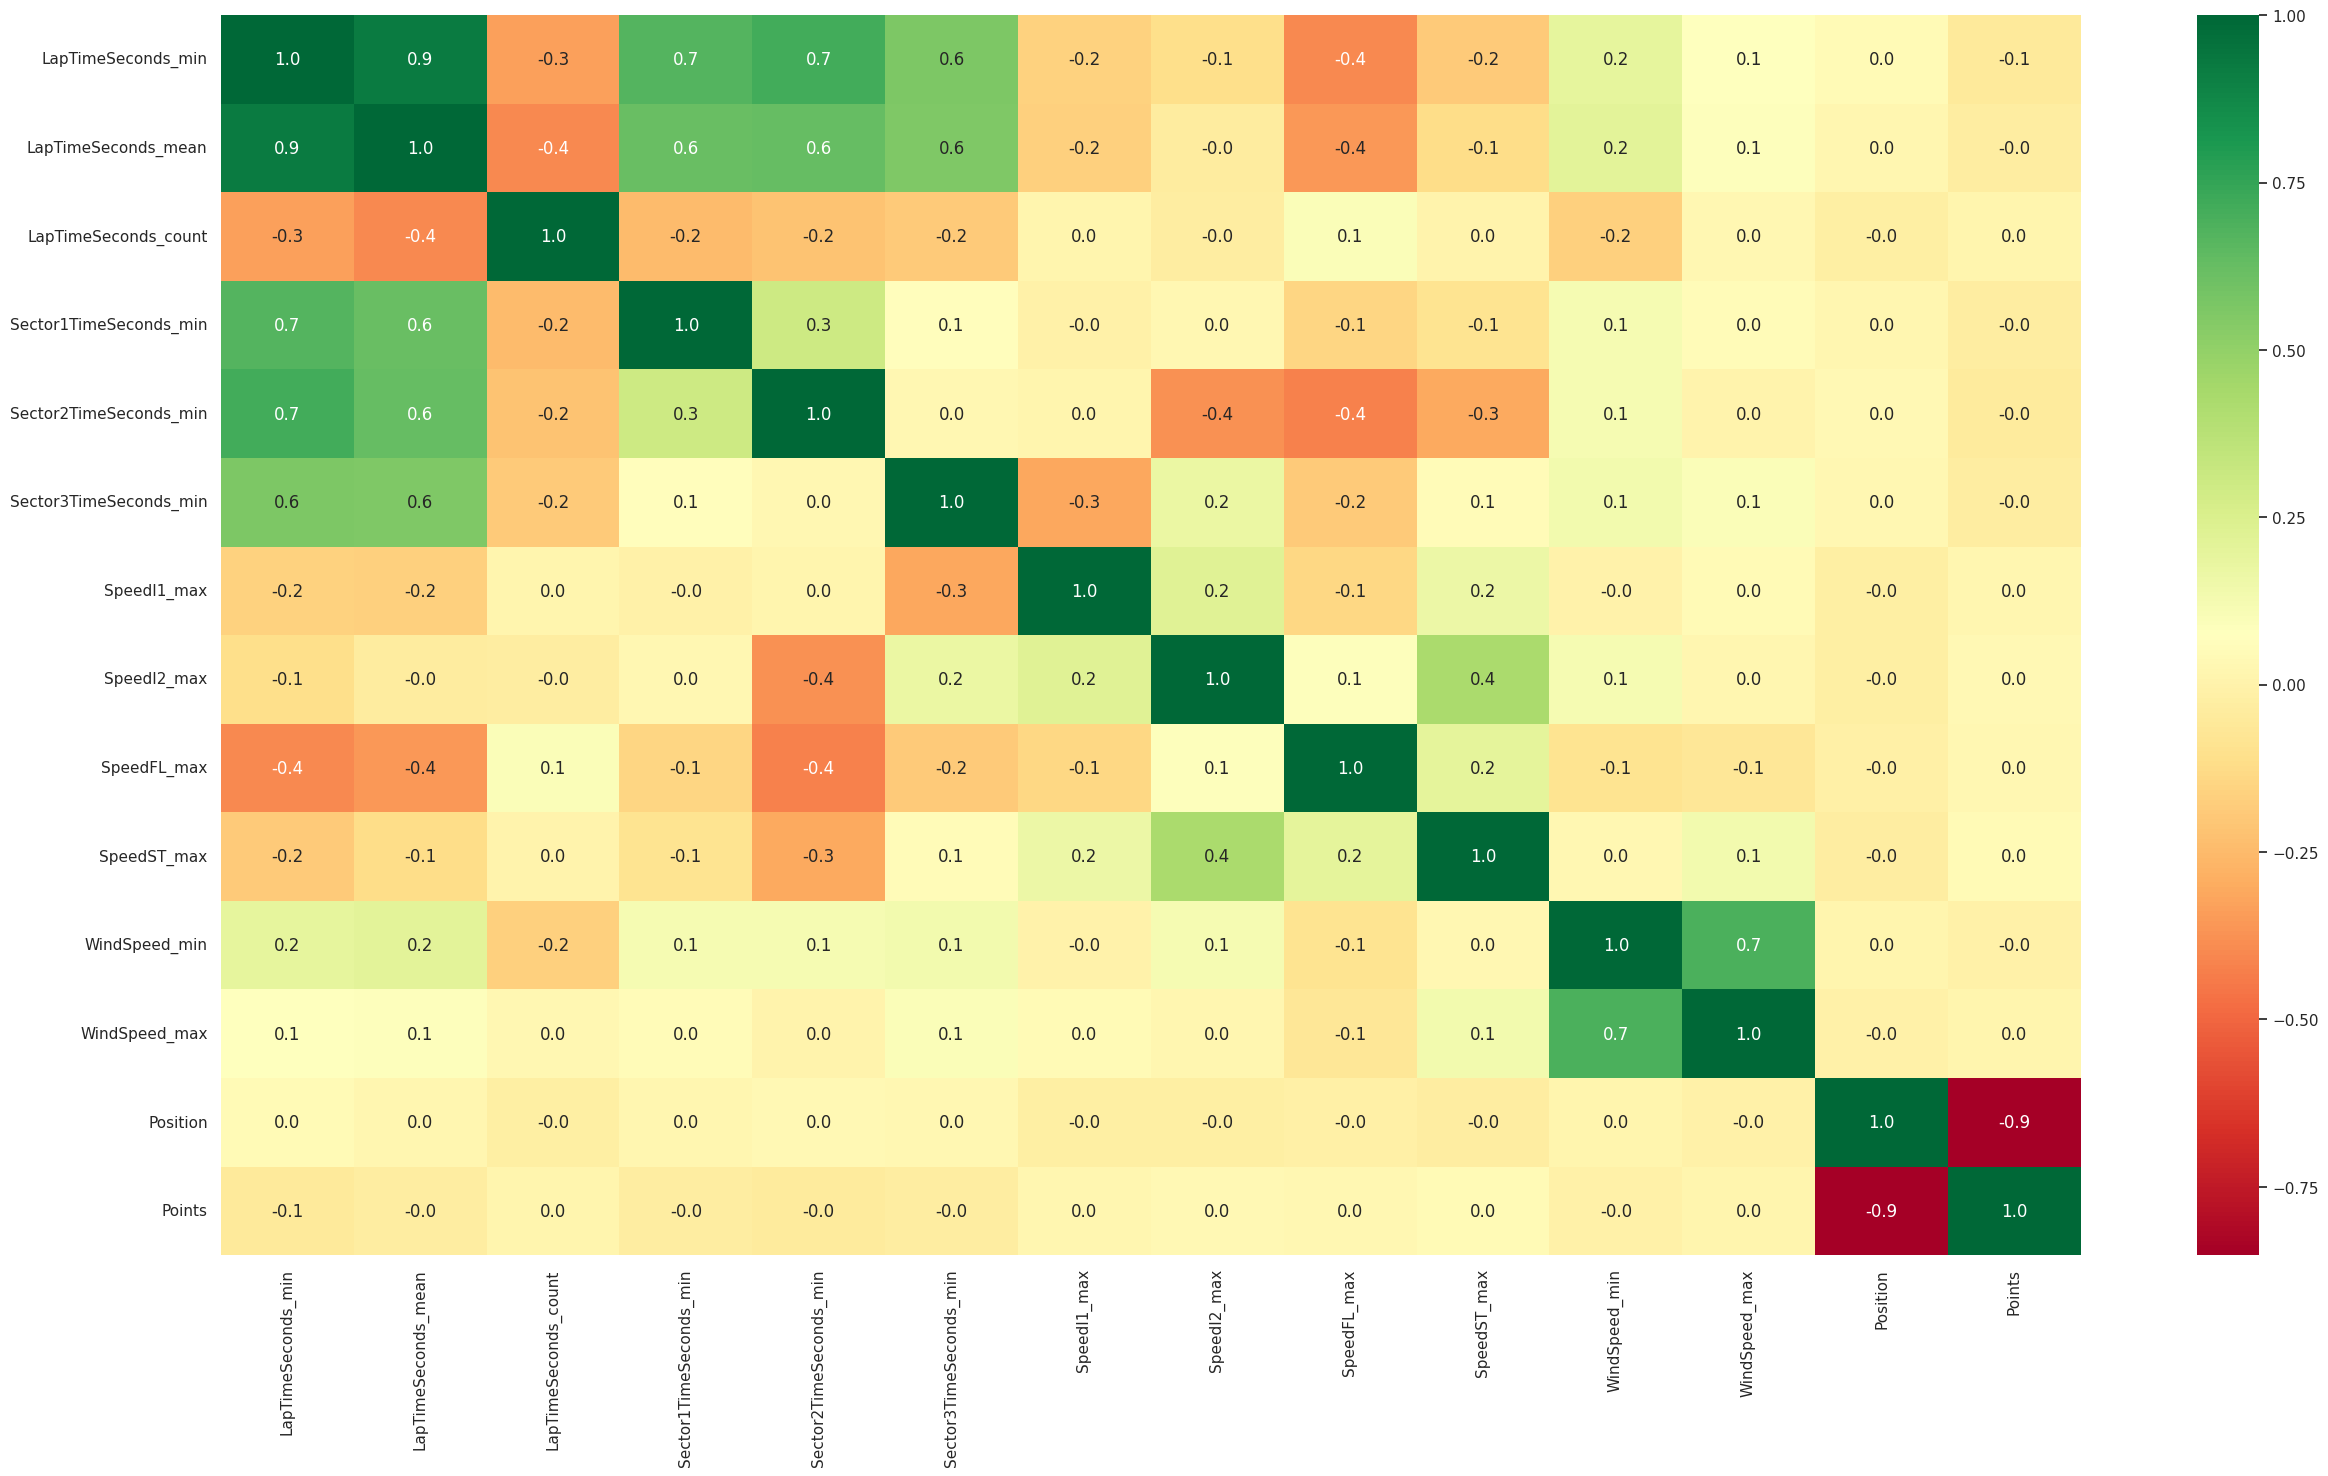

In [11]:
# Only use select features for correlation matrix. Based on personal discretion
corr_select_features = ['LapTimeSeconds_min', 'LapTimeSeconds_mean', 
                        'LapTimeSeconds_count', 'Sector1TimeSeconds_min', 'Sector2TimeSeconds_min', 'Sector3TimeSeconds_min',
                        'SpeedI1_max', 'SpeedI2_max', 'SpeedFL_max', 'SpeedST_max', 'WindSpeed_min', 'WindSpeed_max', 'Position', 'Points']

# Correlation calculations
corr_original = (
    model_data.select_dtypes(['int', 'float'])[corr_select_features]
    .corr().abs()
)

# Graph heatmap of original correlation matrix
ax = (
    sns.heatmap(model_data
                .select_dtypes(['int','float'])[corr_original.index]
                .corr(),
                annot=True,
                cmap='RdYlGn',
                fmt='1.1f')
)
plt.subplots_adjust(bottom=0.26)
plt.show()

<a id="feature-selection"></a>
## Feature Selection

In [12]:
# TODO: Feature Selection

<a id="data-split"></a>
## Data Split

In [13]:
# Unique train test split. It is most helpful to include entire events in the 
# test data to see how things would have been if the model was used. Basically 
# any event after 2023 - Round 5 is used in the Test. Anything before is used 
# for train/validation
train_data = model_data.query('SeasonYear < 2023 or RoundNumber < 5')
test_data = model_data.query('RoundNumber >= 5 & SeasonYear == 2023')

In [14]:
# Points as response variable 
X = train_data.drop(['Points'], axis=1)
y = train_data.Points

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  stratify=X['Position'])

# Prepare test data
X_test = test_data.drop(['Points', 'Position'], axis=1)
y_test = test_data.Points

X_train = X_train.drop(['Position'], axis=1)
X_val = X_val.drop(['Position'], axis=1)

In [15]:
# Define categorical feature indices
categorical_columns_indices = [i for i, dtype in enumerate(X_train.dtypes) 
                               if dtype == object]

In [16]:
# Catboost specific Pool object for train and validation data
train_pool = Pool(X_train, y_train, cat_features=categorical_columns_indices)
val_pool = Pool(X_val, y_val, cat_features=categorical_columns_indices)

<a id="hpo"></a>
## Hyperparameter Optimization

In [31]:
# Hyperparameter space to select from. Following 5 parameters are what appear 
# to be most useful for catboost
space = {
    "learning_rate": tune.loguniform(1e-2, 1),
    "depth": tune.randint(4, 12),
    "l2_leaf_reg": tune.randint(1, 40),
    "min_data_in_leaf": tune.randint(1, 40),
    "iterations": tune.randint(10, 300),
    "thread_count": 4,
    "gpu_ram_part": 0.2,
    "task_type": "GPU"
}

train_data = (X_train, y_train)
validation_data = (X_val, y_val)

# Structure of data passed into ray tune objective function
data = {'train_data': train_data,
        'model_module': 'catboost',
        'model_class_str': 'CatBoostRegressor',
        'metric_class_str': 'mean_squared_error',
        'probability': False,
        'validation_data': validation_data,
        'fit_params': {
            'early_stopping_rounds': 2,
            'verbose': False,
            'cat_features': categorical_columns_indices,
            'eval_set': validation_data,
        },
        'metric_params': {'squared': False},
        'metric_name': 'root_mean_squared_error'
        }

metric_name = data.get('metric_name')
metric_name = metric_name if metric_name else data.get('metric_class_str')

# Search algorithm: HyperOpt uses Tree of Parzen Estimator, a bayesian 
# optimization technique 
hyperopt_search = HyperOptSearch(metric=metric_name, mode="min")

In [32]:
# Ray tune class from src/ray_tuning/ray_tune.py
tuning_class = RayTune(hyperopt_search, space, data)

# Tuner method requires gpu, cpu configuration, max concurrent trials, and 
# total number of samples to optimize with
tuning_config = {'num_gpus': 1}
cpu_per_trial = 4
gpu_per_trial = 0.2
max_concurrent_trials = 4
num_samples = 100

# Results from tuning
results = (
    tuning_class.tuner(tuning_config,
                       max_concurrent_trials,
                       num_samples,
                       cpu_per_trial,
                       gpu_per_trial)
)

2023-07-26 22:36:13,723	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Trial name,date,done,hostname,iterations_since_restore,mean_squared_error,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
objective_02732436,2023-07-26_22-36-23,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.56877,192.168.0.162,96549,4.04105,4.04105,4.04105,1690425383,1,02732436
objective_2e1d98c8,2023-07-26_22-36-20,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.50279,192.168.0.162,96774,1.98996,1.98996,1.98996,1690425380,1,2e1d98c8
objective_39679f66,2023-07-26_22-36-21,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.37041,192.168.0.162,97012,2.98997,2.98997,2.98997,1690425381,1,39679f66
objective_55f025c0,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,6.3885,192.168.0.162,96151,0.233484,0.233484,0.233484,1690425375,1,55f025c0
objective_5be5583c,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.77523,192.168.0.162,96151,0.587153,0.587153,0.587153,1690425375,1,5be5583c
objective_67770434,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,5.00021,192.168.0.162,96151,0.102571,0.102571,0.102571,1690425375,1,67770434
objective_9ed4d8a0,2023-07-26_22-36-17,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.68152,192.168.0.162,96549,1.06038,1.06038,1.06038,1690425377,1,9ed4d8a0
objective_ab7db925,2023-07-26_22-36-18,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.45336,192.168.0.162,96774,1.26931,1.26931,1.26931,1690425378,1,ab7db925
objective_c6af545e,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.76659,192.168.0.162,96151,0.130208,0.130208,0.130208,1690425375,1,c6af545e
objective_cc8f392a,2023-07-26_22-36-19,True,jbalda-B660-GAMING-X-AX-DDR4,1,5.63741,192.168.0.162,96549,1.41192,1.41192,1.41192,1690425379,1,cc8f392a


(objective pid=96549) Warning: less than 75% gpu memory available for training. Free: 5723.6875 Total: 7982.4375
(objective pid=97012) Warning: less than 75% gpu memory available for training. Free: 3933.625 Total: 7982.4375 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(objective pid=97012) Warning: less than 75% gpu memory available for training. Free: 3888.625 Total: 7982.4375 [repeated 5x across cluster]
(objective pid=96151) Warning: less than 75% gpu memory available for training. Free: 4496.75 Total: 7982.4375 [repeated 4x across cluster]
(objective pid=96549) Warning: less than 75% gpu memory available for training. Free: 4291.125 Total: 7982.4375
(objective pid=97012) Warning: less than 75% gpu memory available for training. Free: 4328 Total: 7982.4375
(objective pid=96151) Warning: less than 75% gpu m

In [18]:
# Best result of optimization
best_result = results.get_best_result(metric=metric_name, mode='min')
params = best_result.config
params

{'learning_rate': 0.04018590888878337,
 'depth': 11,
 'l2_leaf_reg': 1,
 'min_data_in_leaf': 2,
 'iterations': 209,
 'thread_count': 4,
 'gpu_ram_part': 0.2,
 'task_type': 'GPU'}

In [17]:
params = {
    'learning_rate': 0.04018590888878337,
    'depth': 11,
    'l2_leaf_reg': 1,
    'min_data_in_leaf': 2,
    'iterations': 100,
    'thread_count': 4,
    'gpu_ram_part': 0.2,
    'task_type': 'GPU'
}

<a id="cv"></a>
## Cross Validation and Final Model Training

In [18]:
final_model = CatBoostRegressor(**params,
                                eval_metric='RMSE')

In [19]:
# 5 fold cross validation
cross_val = cross_validate(final_model,
                           X_train,
                           y_train,
                           fit_params={
                               'eval_set': val_pool,
                               'cat_features': categorical_columns_indices,
                               'verbose': False,
                               'plot': True
                               },
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           return_train_score=True)

In [62]:
print(
    f"Train RMSE: {-1*cross_val['train_score'].mean()} \u00B1 {cross_val['train_score'].std()}"
)

print(
    f"Test RMSE: {-1*cross_val['test_score'].mean()} \u00B1 {cross_val['test_score'].std()}"
)

Train RMSE: 3.3496151840950703 ± 0.0562677905713002
Test RMSE: 4.6710719953647395 ± 0.10986219559027362


In [19]:
# Final model training
final_model.fit(train_pool,
                eval_set=val_pool,
                plot=True,
                early_stopping_rounds=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.0999868	test: 7.0875817	best: 7.0875817 (0)	total: 155ms	remaining: 15.3s
1:	learn: 6.9820843	test: 6.9751665	best: 6.9751665 (1)	total: 229ms	remaining: 11.2s
2:	learn: 6.8595223	test: 6.8681708	best: 6.8681708 (2)	total: 300ms	remaining: 9.69s
3:	learn: 6.7458621	test: 6.7737983	best: 6.7737983 (3)	total: 377ms	remaining: 9.05s
4:	learn: 6.6325144	test: 6.6759686	best: 6.6759686 (4)	total: 442ms	remaining: 8.39s
5:	learn: 6.5304387	test: 6.6035977	best: 6.6035977 (5)	total: 508ms	remaining: 7.96s
6:	learn: 6.4299037	test: 6.5127812	best: 6.5127812 (6)	total: 580ms	remaining: 7.71s
7:	learn: 6.3330888	test: 6.4429656	best: 6.4429656 (7)	total: 654ms	remaining: 7.53s
8:	learn: 6.2436335	test: 6.3678543	best: 6.3678543 (8)	total: 714ms	remaining: 7.22s
9:	learn: 6.1593220	test: 6.2965035	best: 6.2965035 (9)	total: 775ms	remaining: 6.98s
10:	learn: 6.0728876	test: 6.2233943	best: 6.2233943 (10)	total: 847ms	remaining: 6.85s
11:	learn: 5.9944461	test: 6.1580727	best: 6.1580727

<a id="importance"></a>
## Feature Importance

In [25]:
# Tree-based feature importance
feature_importance = (
    pd.DataFrame({'Feature': final_model.feature_names_, 
                  'Importance': final_model.feature_importances_})
)

# Sort feature importance
feature_importance_sorted = (
    feature_importance
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

# Top 20 features
feature_importance_top20 = feature_importance_sorted.iloc[0:20]
feature_importance_top20

,Feature,Importance
0,TeamId,32.362454
1,Driver,9.612218
2,SeasonYear,4.319405
3,SpeedFL_std,1.710691
4,SpeedST_std,1.707910
5,SpeedI1_min,1.702077
6,Sector1TimeSeconds_min,1.687673
7,SpeedST_min,1.619797
8,SpeedFL_min,1.576906
9,SpeedI1_mean,1.471650


In [27]:
# To 20 features to markdown for README
feature_importance_top20.to_markdown('results/top_20_feature_importance.md')

<a id="combinations"></a>
## Catboost for Combination of Predictions

Each race weekend has around 4 potential predictions since the data is on the session grain. This means that for each driver, they may have a prediction for Practice 1-3 and Qualifying. This section trains a machine learning model with those 4 predictions to essentially calcualte the weights of each session automatically. The final result is one single prediction for the entire race weekend.

One caveat, the data is trained on data where a driver has a complete race weekend. Future work could be to train multiple models based on which sessions the driver has available.

In [20]:
# Only train on data for drivers with 4 full sessions in a race
complete_events_mask = (
    train_data.groupby(['Driver', 'EventName', 'SeasonYear'])
    ['SessionType'].nunique() == 4
)

# Filter down to just those racer results
filtered_df = train_data.merge(complete_events_mask,
                               left_on=['Driver', 'EventName', 'SeasonYear'], right_index=True)
filtered_df = filtered_df.query('SessionType_y == True')
filtered_df = (
    filtered_df.sort_values(['SeasonYear',
                             'RoundNumber',
                             'Driver',
                             'SessionType_x'], ascending=False)
                             .reset_index(drop=True)
                             .drop('SessionType_y', axis=1)
)
filtered_df = filtered_df.rename(columns={'SessionType_x': 'SessionType'})

filtered_df_X = filtered_df[X_train.columns].copy()
points = filtered_df.Points.values[::4]

# Predict a single prediction for the 4 session predictions for each racer
y_train_pred = final_model.predict(filtered_df_X)

reg_features = y_train_pred.reshape(-1, 4)

# Train - Validation split
X_train_reg, X_val_reg, y_train_reg, y_val_reg = (
    train_test_split(reg_features, points)
)

In [21]:
# Train the model on 4 features to predict race points
cb = CatBoostRegressor()
cb.fit(X_train_reg, y_train_reg, eval_set=(X_val_reg, y_val_reg))

Learning rate set to 0.05122
0:	learn: 7.2161494	test: 6.4925957	best: 6.4925957 (0)	total: 561us	remaining: 561ms
1:	learn: 6.9441459	test: 6.2573334	best: 6.2573334 (1)	total: 916us	remaining: 457ms
2:	learn: 6.6984699	test: 6.0360859	best: 6.0360859 (2)	total: 1.23ms	remaining: 408ms
3:	learn: 6.4620555	test: 5.8372820	best: 5.8372820 (3)	total: 1.61ms	remaining: 400ms
4:	learn: 6.2420427	test: 5.6458040	best: 5.6458040 (4)	total: 1.96ms	remaining: 389ms
5:	learn: 6.0350064	test: 5.4642171	best: 5.4642171 (5)	total: 2.28ms	remaining: 378ms
6:	learn: 5.8412101	test: 5.3026181	best: 5.3026181 (6)	total: 2.62ms	remaining: 372ms
7:	learn: 5.6555962	test: 5.1380640	best: 5.1380640 (7)	total: 2.92ms	remaining: 362ms
8:	learn: 5.4847239	test: 4.9935083	best: 4.9935083 (8)	total: 3.25ms	remaining: 358ms
9:	learn: 5.3250733	test: 4.8520861	best: 4.8520861 (9)	total: 3.59ms	remaining: 356ms
10:	learn: 5.1730637	test: 4.7179663	best: 4.7179663 (10)	total: 3.92ms	remaining: 352ms
11:	learn: 5.0

In [22]:
# Obtain new RMSE of single prediction for race weekend
reg_pred = cb.predict(X_val_reg)
rmse = mean_squared_error(y_val_reg, reg_pred)**(1/2)
rmse

3.05541727706465

<a id="results"></a>
## Testing/Results

In [26]:
# Avaiable round numbers in 2023 season for testing
round_numbers = test_data['RoundNumber'].unique()
round_numbers

array([5, 6, 7, 8])

In [38]:
def get_race_predictions(round_number: int,
                         season_year: int,
                         markdown: bool = False) -> pd.DataFrame:

    # Query to single race data
    # Sort to put driver predictions in order 
    race_data = (
        test_data.sort_values(['DriverNumber',
                               'RoundNumber',
                               'SessionType'])
                  .reset_index(drop=True)
                  .query('(RoundNumber == @round_number) & (SeasonYear == @season_year)')
    )

    # Get relevent result data
    results = race_data[['Driver',
                         'EventName',
                         'SeasonYear',
                         'Position',
                         'Points']]

    # make initial predictions on the session level
    predictions = final_model.predict(race_data.drop(['Position', 'Points'], 
                                                     axis=1))
    
    # Reshape to 4 predictions per driver NOTE: Need to make sure each driver 
    # has 4 predictions
    predictions_reg = predictions.reshape(-1, 4)

    # Predict 1 score
    predictions = cb.predict(predictions_reg)

    # Put results into table 
    results_select = (
        results.iloc[::4]
        .reset_index(drop=True)
    )
    # Add predictions
    results_select['PredictedPoints'] = predictions

    # Final result table
    race_results = (
        results_select.sort_values('PredictedPoints',
                                   ascending=False)
                      .reset_index(drop=True)
    )
    # Specification if race results should be saved
    if markdown:
        race_results.to_markdown(
                f'results/{season_year}-round{round_number}.md'
                )
    return race_results

In [39]:
# Miami Grand Prix in 2023
get_race_predictions(5, 2023)

,Driver,EventName,SeasonYear,Position,Points,PredictedPoints
0,VER,Miami Grand Prix,2023,1.0,26.0,19.720149
1,HAM,Miami Grand Prix,2023,6.0,8.0,14.519783
2,PER,Miami Grand Prix,2023,2.0,18.0,14.263243
3,RUS,Miami Grand Prix,2023,4.0,12.0,10.534643
4,SAI,Miami Grand Prix,2023,5.0,10.0,8.700970
5,LEC,Miami Grand Prix,2023,7.0,6.0,7.035478
6,OCO,Miami Grand Prix,2023,9.0,2.0,4.048613
7,ALO,Miami Grand Prix,2023,3.0,15.0,3.808359
8,NOR,Miami Grand Prix,2023,17.0,0.0,3.784015
9,GAS,Miami Grand Prix,2023,8.0,4.0,2.885384


In [40]:
# Save race results for 4 rounds in season 2023
# Inside results folder
for round in round_numbers:
    get_race_predictions(round, 2023, True)

-------------------------------